# Space Mice Genes
## Heat Propagation and Clustering Package
### Python 2 compatible version

----------------------

Author: Mikayla Webster (13webstermj@gmail.com)

Date: 6th April, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Define Analysis Preferences](#pref)
3. [Load Networks](#load)
4. [Run Heat Propagation](#heat)
5. [Clustering](#cluster)

## Background
<a id='background'></a>

## Import packages
<a id='import'></a>

In [99]:
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)

import Heat2
reload(Heat2)

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Define Analysis Preferences
<a id='pref'></a>

In [100]:
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

heat = Heat2.Heat(gene_type = symbol, species = mouse)

## Load Networks
<a id='load'></a>

1. Load STRING background network
2. Load DEG file 

In [76]:
#filename = '../../background_networks/10090.protein.links.v10.5.txt'
#heat.load_STRING_links(filename, confidence_filter = 700)

#print('\nNumber of interactions: ' + str(len(list(heat.DG_universe.edges()))))

In [87]:
# load DEG file
DEG_filename = '../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv'  
heat.create_DEG_list(DEG_filename, p_value_filter = 0.02, sep = ',')

print('Number of DEG\'s: ' + str(len(heat.DEG_list)))

Number of DEG's: 45


In [88]:
#saved_DG_universe = heat.DG_universe
heat.DG_universe = saved_DG_universe

## Localization

Wait until meeting with Brin on Wed before deciding to extract this to a file.

In [ ]:
def calc_localization(Gint, focal_genes, num_reps = 10, sample_frac = 0.8, method = 'numedges'):
    
    '''
    function to calculate localization of an input set of genes (focal_genes) on a background network (Gint).
    - subsample sample_frac of input genes 
    - use method = 'numedges', 'LCC', or 'both
    
    '''
    bins = get_degree_binning(Gint, 10)
    min_degree, max_degree, genes_binned = zip(*bins)
    bin_df = pd.DataFrame({'min_degree':min_degree, 'max_degree':max_degree, 'genes_binned':genes_binned})
    first_it = True
    
    focal_genes = list(np.intersect1d(focal_genes, Gint.nodes())) # only use focal_genes which are in Gint

    numedges_list = []
    numedges_rand = []
    LCC_list = []
    LCC_rand = []
    
    for r in range(num_reps):
        
        if (r % 25)==0:
            print(r)
        focal_80 = focal_genes
        np.random.shuffle(focal_80)
        focal_80 = focal_80[:int(len(focal_80) * sample_frac)]

        seed_random = []
        for g in focal_80:
            
            degree_temp = nx.degree(Gint, g)
            #degree_temp = 0
            # find genes with similar degrees to focal gene degree
            genes_temp = bin_df[(bin_df['min_degree'] <= degree_temp) & (bin_df['max_degree'] >= degree_temp)]['genes_binned'].tolist()[0]
            np.random.shuffle(genes_temp) # shuffle them
            seed_random.append(genes_temp[0]) # build the seed_D1_random list

        if (method == 'numedges') or (method == 'both'):
            
            numedges_temp = len(nx.subgraph(Gint, focal_80).edges())
            numedges_list.append(numedges_temp)
            
            numedges_temp_rand = len(nx.subgraph(Gint, seed_random).edges())
            numedges_rand.append(numedges_temp_rand)
            
        if (method == 'LCC') or (method == 'both'):
            
           # if (sample_frac != 1) | (first_it == True):
            first_it = False
            G_sub_temp = nx.subgraph(Gint, focal_80)
            G_sub_temp = max(nx.connected_component_subgraphs(G_sub_temp), key = len)
            LCC_list.append(len(G_sub_temp.nodes()))
           # else:
            #    LCC_list.append(LCC_list[0])
            
            G_sub_temp = nx.subgraph(Gint, seed_random)
            G_sub_temp = max(nx.connected_component_subgraphs(G_sub_temp), key = len)
            LCC_rand.append(len(G_sub_temp.nodes()))
    return numedges_list, numedges_rand, LCC_list, LCC_rand
    

In [ ]:
def get_degree_binning(g, bin_size, lengths=None):
    '''
    This function comes from network_utilities.py of emregtoobox.  
    '''
    degree_to_nodes = {}
    for node, degree in g.degree().iteritems():
        if lengths is not None and node not in lengths:
            continue
        degree_to_nodes.setdefault(degree, []).append(node)
    values = degree_to_nodes.keys()
    values.sort()
    bins = []
    i = 0
    while i < len(values):
        low = values[i]
        val = degree_to_nodes[values[i]]
        while len(val) < bin_size:
            i += 1
            if i == len(values):
                break
            val.extend(degree_to_nodes[values[i]])
        if i == len(values):
            i -= 1
        high = values[i]
        i += 1 
        #print low, high, len(val)
        if len(val) < bin_size:
            low_, high_, val_ = bins[-1]
            bins[-1] = (low_, high, val_ + val)
        else:
            bins.append((low, high, val))
    return bins

In [ ]:
# load DEG file
DEG_filename = '../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv'  
heat.create_DEG_list(DEG_filename, p_value_filter = 0.1, sep = ',')

print('Number of DEG\'s: ' + str(len(heat.DEG_list)))

In [ ]:
numedges_list, numedges_rand, LCC_list, LCC_rand = calc_localization(heat.DG_universe, heat.DEG_list, 
                                                                     num_reps = 200, method = 'both')

In [ ]:
# M 4.6.18 8:30 -  
#
#normal: 90 s
# w/o shuffling: 82s, 76s
# w/o nx.degree: 82s, 76s, 76s
# unfortunately it seems the answer is in the 2 nested for loops

In [ ]:
fig, ax = plt.subplots(figsize = (12, 7))
for data in [numedges_list, numedges_rand]:
    sns.distplot(data, ax = ax, hist = True)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 7))
for data in [LCC_list, LCC_rand]:
    sns.distplot(data, ax = ax)

In [ ]:
import time
start = time.time()
# sample fraction = 100 %
numedges_list, numedges_rand, LCC_list, LCC_rand = calc_localization(heat.DG_universe, heat.DEG_list, 
                                                                     num_reps = 200, sample_frac = 1, method = 'LCC')
print "Process time: " + str(time.time() - start)

In [ ]:
LCC_list

In [ ]:
# plot distributions for non-sampled case
sns.set_style('white') 
plt.vlines(np.mean(LCC_list), ymin = 0, ymax = 0.1, color = 'r', lw = 2, label = 'ASD DNVs')
sns.kdeplot(LCC_rand, color = 'k', lw = 2, alpha = 0.5, shade = True, label = 'random')
plt.legend(loc = 'upper left', fontsize = 12)
plt.ylabel('frequency', fontsize = 16)
plt.xlabel('largest connected component', fontsize = 16)

# print the z-score and fdr
LCC_z = (np.mean(LCC_list) - np.mean(LCC_rand))/np.std(LCC_rand)

from scipy.special import ndtr
print(1 - ndtr(LCC_z))

plt.title('permutation p = ' + str(1 - ndtr(LCC_z)))

## Run Heat Propagation
<a id='heat'></a>

In [79]:
#heat.normalized_adj_matrix()

In [89]:
#saved_Wprime = heat.Wprime
heat.Wprime = saved_Wprime

In [58]:
heat.draw_heat_prop(num_nodes = 200,
                  random_walk = True,
                  edge_width = 2,
                  edge_smooth_enabled = True,
                  edge_smooth_type = 'bezier',
                  node_size_multiplier = 5,
                  hover = False,
                  hover_connected_edges = False,
                  largest_connected_component = True,
                  physics_enabled = True,
                  node_font_size = 40,
                  graph_id = 1,
                  node_shadow_x = 6)

## Clustering 
<a id='cluster'></a>

Parameter information:
- **G_DEG**: background network filtered by DEG list, output of load_STRING_to_digraph
- **DG_universe**: full background network, output of create_graph.load_STRING_to_digraph 
- **seed_nodes**: list of DEG's, output of create_graph.create_DEG_list
- **Wprime**: will calculate automatically of not specified, output of visualizations.normalized_adj_matrix
- **num_top_genes**: number of genes to display in the output graph
- **cluster_size_cut_off**: color clusters below this threshhold grey
- **remove_stray_nodes**: remove custers below the cluster size cut off
- **r**: increases spacing between clusters. recommended number between 0.5 and 4.0
- **x_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **y_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **node_spacing**: recommended number between 500 and 2000
- **node_size_multiplier**: as you scale node_spacing, scale this number. Recommended number between 5 and 25
- **physics_enabled**: Nodes will bounce aroound when you click and drag them. Only set to True when number of nodes is 200 or less
- **node_font_size**: as you scale node_spacing, scale this number. Recommended number between 20 and 50
- **graph_id**: Allows rendering of multiple graphs in one notebook. Just make sure each graph has a unique id. 

In [59]:
heat.draw_clustering(rad_positions = False,
                k = None,
                largest_connected_component = True,
                num_top_genes = 200,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 700,
                node_size_multiplier = 10,
                physics_enabled = True,
                node_font_size = 40,
                graph_id = 2,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                hover_connected_edges = False
               )

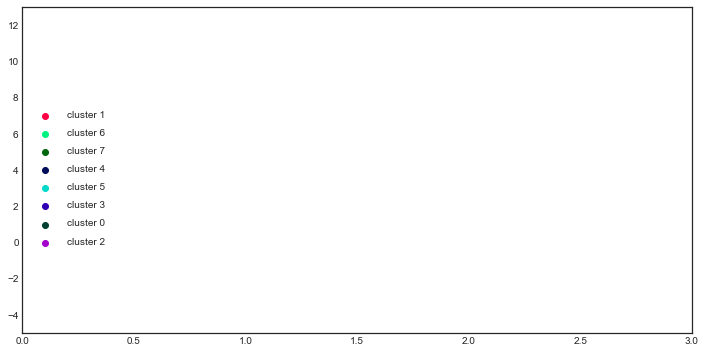

In [60]:
heat.cluster_legend(cluster_size_cut_off = 5)

In [90]:
heat.draw_clustering(num_top_genes = 200,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                r = 0.4,
                node_spacing = 600,
                node_size_multiplier = 4,
                physics_enabled = False,
                node_font_size = 15,
                graph_id = 3,
                node_shadow_x = 6,
                color_lfc = True,
                largest_connected_component = True,
                vmin = -1,
                vmax = 1
               )

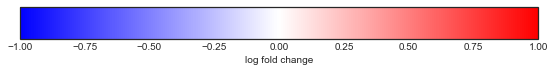

In [103]:
heat.draw_legend(vmin = -1, vmax = 1, label = 'log fold change')

In [24]:
#heat.write_cluster_table('cluster_table_2.csv')